# TSMixer model
> Tutorial on how to train and forecast TSMixer models.

[Short description]

Our implementation of all these models are multivariate, which means that all timeseries are forecast jointly. 

In this notebook we will show how to:
* Load the [ETTm2](https://github.com/zhouhaoyi/ETDataset) benchmark dataset, used in the academic literature.
* Train models
* Forecast the test set

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/LongHorizon_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing libraries

In [ ]:
%%capture
!pip install neuralforecast datasetsforecast

## 2. Load ETTm2 Data

The `LongHorizon` class will automatically download the complete ETTm2 dataset and process it.

It return three Dataframes: `Y_df` contains the values for the target variables, `X_df` contains exogenous calendar features and `S_df` contains static features for each time-series (none for ETTm2). For this example we will only use `Y_df`.

If you want to use your own data just replace `Y_df`. Be sure to use a long format and have a simmilar structure than our data set.

In [1]:
import pandas as pd

from datasetsforecast.long_horizon import LongHorizon

In [2]:
# Change this to your own data to try the model
Y_df, _, _ = LongHorizon.load(directory='./', group='ETTm2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

# Y_df.groupby('unique_id').head(2)

## 3. Train models

We will train models using the `cross_validation` method, which allows users to automatically simulate multiple historic forecasts (in the test set).

The `cross_validation` method will use the validation set for hyperparameter selection and early stopping, and will then produce the forecasts for the test set.

First, instantiate each model in the `models` list, specifying the `horizon`, `input_size`, and training iterations.

(NOTE: The `FEDformer` model was excluded due to extremely long training times.)

In [3]:
%%capture
from neuralforecast.core import NeuralForecast
from neuralforecast.models import Informer, Autoformer, PatchTST, TSMixer
from neuralforecast.losses.pytorch import MSE, MAE

In [13]:
%%capture
horizon = 96
input_size = 512
models = [
      #     Informer(h=horizon,                 # Forecasting horizon
      #           input_size=input_size,           # Input size
      #           max_steps=1000,               # Number of training iterations
      #           val_check_steps=100,          # Compute validation loss every 100 steps
      #           early_stop_patience_steps=3), # Stop training if validation loss does not improve
      #     Autoformer(h=horizon,
      #           input_size=input_size,
      #           max_steps=1000,
      #           val_check_steps=100,
      #           early_stop_patience_steps=3),
      #     PatchTST(h=horizon,
      #           input_size=input_size,
      #           max_steps=1000,
      #           val_check_steps=100,
      #           early_stop_patience_steps=3),
          TSMixer(h=horizon,
                input_size=input_size,
                n_series=7,
                max_steps=2500,
            #     val_check_steps=1.0,
            #     early_stop_patience_steps=5,
                learning_rate=0.001,
                n_block=2,
                dropout=0.9,
                ff_dim=64,
                loss=MAE(),
                scaler_type='identity',
                batch_size=32,
                valid_loss=MAE(),
                ),                                                           
         ]

INFO:lightning_fabric.utilities.seed:Seed set to 1


:::{.callout-tip}
Check our `auto` models for automatic hyperparameter optimization.
:::

Instantiate a `NeuralForecast` object with the following required parameters:

* `models`: a list of models.

* `freq`: a string indicating the frequency of the data. (See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

Second, use the `cross_validation` method, specifying the dataset (`Y_df`), validation size and test size.

In [14]:
%%capture
nf = NeuralForecast(
    models=models,
    freq='15min')

Y_hat_df = nf.cross_validation(df=Y_df,
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None,
                               sort_df=False)       
Y_hat_df = Y_hat_df.reset_index()                               

# Y_train_df = Y_df[Y_df['ds'] < Y_df['ds'].values[-val_size]]
# Y_test_df = Y_df[Y_df['ds'] >= Y_df['ds'].values[-val_size]]

# nf.fit(df=Y_train_df, val_size=val_size)     
# Y_hat_df = nf.predict(Y_test_df)
# Y_hat_df = Y_hat_df.reset_index()                   


The `cross_validation` method will return the forecasts for each model on the test set.

## 4. Evaluate Results

Next, we plot the forecasts on the test set for the `OT` variable for all models.

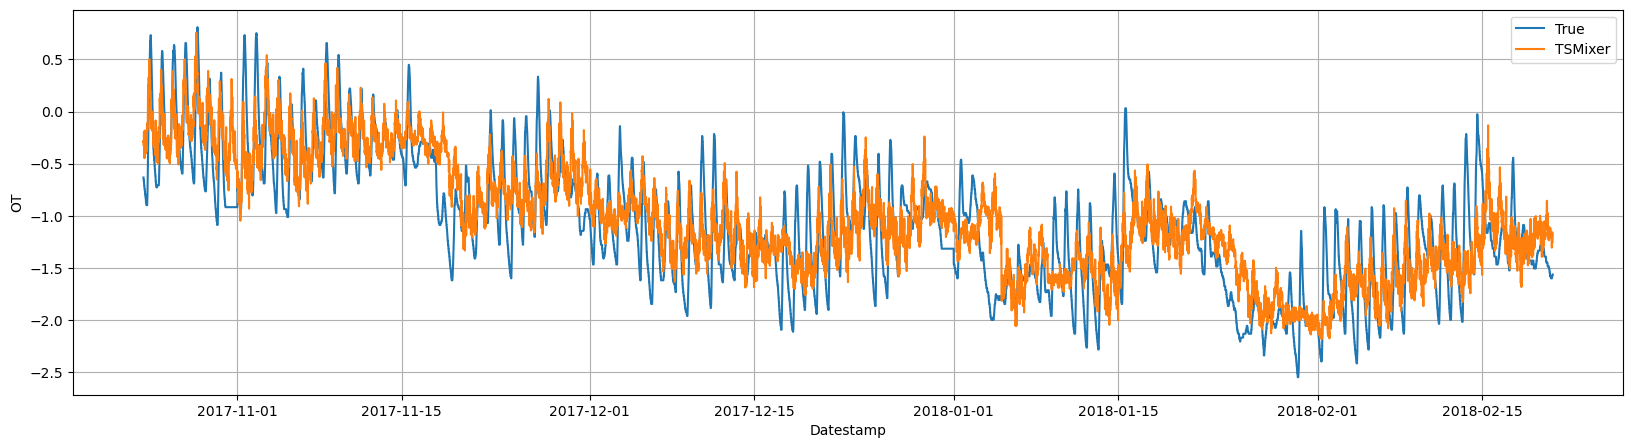

In [15]:
import matplotlib.pyplot as plt
Y_plot = Y_hat_df[Y_hat_df['unique_id']=='OT'] # OT dataset
cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['TSMixer'], label='TSMixer')
# plt.plot(Y_plot['ds'], Y_plot['Autoformer'], label='Autoformer')
# plt.plot(Y_plot['ds'], Y_plot['PatchTST'], label='PatchTST')
# plt.plot(Y_plot['ds'], Y_plot['Informer'], label='Informer')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()

Finally, we compute the test errors using the Mean Absolute Error (MAE) and Mean Squared Error (MSE):

$\qquad MAE = \frac{1}{Windows * Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}| \qquad$ and $\qquad MSE = \frac{1}{Windows * Horizon} \sum_{\tau} (y_{\tau} - \hat{y}_{\tau})^{2} \qquad$

In [16]:
from neuralforecast.losses.numpy import mse, mae

mae_tsmixer = mae(Y_hat_df['y'], Y_hat_df['TSMixer'])
mse_tsmixer = mse(Y_hat_df['y'], Y_hat_df['TSMixer'])

mae_paper = {96:0.252,
             192:0.290,
             336:0.324,
             720:0.422}

mse_paper = {96:0.163,
             192:0.216,
             336:0.268,
             720:0.420}

print(f'TSMixer horizon {horizon} - MAE: {mae_tsmixer:.3f} (Paper: {mae_paper[horizon]})')
print(f'TSMixer horizon {horizon} - MSE: {mse_tsmixer:.3f} (Paper: {mse_paper[horizon]})')


TSMixer horizon 96 - MAE: 0.347 (Paper: 0.252)
TSMixer horizon 96 - MSE: 0.281 (Paper: 0.163)


In [ ]:
Y_hat_df

For reference, we can check the performance when compared to self-reported performance in their respective papers.

Mean Absolute Error (MAE)

| Horizon   | TSMixer   | PatchTST     | AutoFormer | Informer 
|---        |---        |---           |---         |---       
|  96       | 0.252     |  0.256       |   0.339    |  0.453   
|  192      | 0.290     |  0.296       |   0.340    |  0.563   
|  336      | 0.324     |  0.329       |   0.372    |  0.887   
|  720      | 0.422     |  0.385       |   0.419    |  1.388  

Mean Squared Error (MSE)

| Horizon   | TSMixer   | PatchTST     | AutoFormer | Informer 
|---        |---        |---           |---         |---      
|  96       | 0.163     |  0.166       |   0.205    |  0.355   
|  192      | 0.216     |  0.223       |   0.278    |  0.595   
|  336      | 0.268     |  0.274       |   0.343    |  1.270   
|  720      | 0.420     |  0.362       |   0.414    |  3.001  

## Tuning the hyperparameters

In [ ]:
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.auto import AutoTSMixer

tsmixer_config = {
       "input_size": input_size,                                                 # Size of input window

       "max_steps": 100,   
       "val_check_steps": 1,                                                     # Compute validation every 1 steps
       "early_stop_patience_steps": 5,                                           # Number of Adam steps
       "learning_rate": tune.loguniform(1e-5, 1e-1),                             # Initial Learning rate

       "n_block": tune.choice([1, 2, 3, 4, 5, 6, 7, 8]),                         # Number of mixing layers
       "dropout": tune.uniform(0.0, 0.99),                                       # Dropout
       "ff_dim": tune.choice([32, 64, 128, 256, 512]),                           # MaxPool's Kernelsize

       "scaler_type": 'identity',       
       
    }

In [ ]:
model = AutoTSMixer(h=horizon,
                    n_series=7,
                    loss=MSE(),
                    config=tsmixer_config,
                    search_alg=HyperOptSearch(),
                    backend='ray',
                    num_samples=10,
                    valid_loss=MAE())

In [ ]:
%%capture
nf = NeuralForecast(models=[model], freq='15min')
nf.fit(df=Y_df, val_size=val_size)

In [ ]:
# results = nf.models[0].results.trials_dataframe()
nf.models[0].results